In [99]:
import pandas as pd

In [100]:
games = pd.read_csv("matches.csv", index_col=0)

Using only regular season games as our dataset

In [101]:
games  = games.loc[games["round"] == "Regular Season"]

Let's look at the columns in the data frame

In [102]:
games.columns

Index(['date', 'time', 'comp', 'round', 'day', 'venue', 'result', 'gf', 'ga',
       'opponent', 'xg', 'xga', 'poss', 'attendance', 'captain', 'formation',
       'referee', 'match report', 'notes', 'sh', 'sot', 'dist', 'fk', 'pk',
       'pkatt', 'season', 'team'],
      dtype='object')

Deleting all the non-numerical values that won't be used

In [103]:
del games["comp"]
del games["notes"]
del games["match report"]
del games["referee"]
del games["time"]
del games["season"]
del games["captain"]
del games["attendance"]

The results column is what we will be predicting. Right we now will predict a win or a non-win (loss or tie). We are not predicting points gain or loss through out the season. 

In [104]:
# Converting results column into an integer input of 1 or 0 
games["target"] = (games["result"] == "W").astype("int")

For the following categories we have to encoded the different categories numerical so the 
random forrest model can read it 

In [105]:
# Coding the formation into a numerical category 
games["for_code"] = games["formation"].astype("category").cat.codes

In [106]:
games["venue_code"] = games["venue"].astype("category").cat.codes

In [107]:
# Coding the opponent into a numerical category
games["opp_code"] = games["opponent"].astype("category").cat.codes

In [108]:
# Coding the home team into a numerical category
games["team_code"] = games["team"].astype("category").cat.codes

We chose our features for the model. In this case possession, opponent, shots, shots on target, formation, XG, and XG against were chosen

In [109]:
# Choosing our features 
predictors = ["opp_code", "for_code", "venue_code"]

In [169]:
# Setting up our target value and our features for the machine model 
y = games["target"]
x = games[predictors]

In [170]:
# Splitting test and training data. Test data will be 20% of the total games
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=10)

Random Forest Classifier is used because of it's ability to handle regression and classification. It's a great model because it can handle XG and XGA (regression) and opponent and formation (classification)

In [112]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from scipy.stats import randint

Below we are gonna look for the best parameters for the RandomForestClassifier

In [113]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(x_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fe243e12b50>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fe243e2a1c0>})

In [114]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 5, 'n_estimators': 149}


We add "n_estimators" and "max_depth" into the parameters


In [171]:
# Setting up our machine learning model
rf = RandomForestClassifier(n_estimators=302, max_depth=5, min_samples_split=5, random_state=0)

In [172]:
# Fitting our model to the data
rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=5, min_samples_split=5, n_estimators=302,
                       random_state=0)

In [173]:
# Predicting our data set 
y_preds = rf.predict(x_test)

Now we match how well the machine learning algorithm did versus the actual test target 


In [174]:
# Calculating accuracy
acc = accuracy_score(y_test, y_preds)
print(acc)

0.6


Below we check out the influence of each feature in the algorithm

In [175]:
for col, val in sorted(
    zip(x_train.columns, rf.feature_importances_,),
     key=lambda x: x[1], reverse=True,
     )[:7]:
     print(f"{col:10}{val:10.3f}")
     

opp_code       0.425
venue_code     0.341
for_code       0.234


Opposition plays the largest role in the algorithm in predicting results


In [176]:
from sklearn.metrics import confusion_matrix
import matplotlib as plt
import matplotlib.pyplot as plt

Below we'll compare the actual results vs the predicted results and how they match up

In [177]:
combined = pd.DataFrame(dict(actual=y_test, predicted=y_preds))
pd.crosstab(index=combined["actual"], columns=combined["predicted"])
# This is a quick way of seeing the results

predicted,0,1
actual,,
0,149,41
1,81,34


We're going to create a confusion matrix to visualize the results. We'll use seaborn and matplotlib modules to create the visualization

In [178]:
# Creating the confusion matrix variable
cm=confusion_matrix(y_test, y_preds, labels=[0, 1])

In [179]:
import seaborn as sns
import matplotlib.pyplot as plt

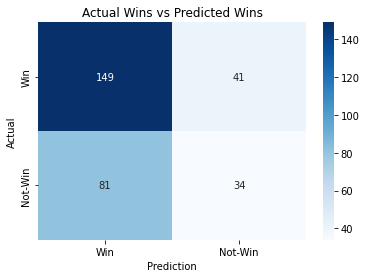

In [180]:
sns.heatmap(cm,
            annot=True,
            cmap=plt.cm.Blues,
            fmt='g',
            xticklabels=['Win', 'Not-Win'],
            yticklabels=['Win', 'Not-Win'])

plt.title("Actual Wins vs Predicted Wins")
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.savefig("cm.jpg")
plt.show()

Below is the legend for ths graph: 

* TP = True Positive (Actual Win)
* TN = True Negative (Actual "Non-Win")
* FP = False Positive (Not a  Win)
* FN = False Negative (Not a "Non-Win")

* cm[0][0] = TP
* cm[1][1] = TN
* cm[0][1] = FP
* cm[1][0] = FN

We're gonna try and improve the algorithm by adding information from past games. We'll use rolling averages from the past 5 games to to be added to each row or each game

In [125]:
# Group the games by team
grouped_matches = games.groupby("team")

Creating a function that will get the averages from the last 5 games and creat the corresponding columns 

In [126]:
def rolling_averages(group, cols, new_cols):
    group = group.sort_values("date")
    rolling_stats = group[cols].rolling(5, closed='left').mean()
    group[new_cols] = rolling_stats
    group = group.dropna(subset=new_cols)
    return group



In [127]:
# Creating the new columns and adding them to the data frame
cols = ["xg", "xga", "sh", "sot", "dist", "poss"]
new_cols = [f"{c}_avg" for c in cols]

games_rolling = games.groupby("team").apply(lambda x: rolling_averages(x, cols, new_cols))

In [128]:
# Removing the 'team' category so all the games are sorted by date 
games_rolling = games_rolling.droplevel('team')

In [129]:
# Removing the 'team' index and resetting the index bast on the length of the data frame 
games_rolling.index = range(games_rolling.shape[0])

Implimenting the features that included the averages and data into a new RandomForestClassifier with a 80-20 split

In [130]:
y = games_rolling["target"]
x = games_rolling[predictors + new_cols]

In [159]:
# Running the algorithm and checking the accuracy
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=12)
rf.fit(x_train, y_train)
preds = rf.predict(x_test)
acc = accuracy_score(y_test, preds)

In [160]:
acc

0.65625

We see that addding the average from the past games improves the algorithm only slightly

In [165]:
# Checking the influence of each feature in the algorithim 
for col, val in sorted(
    zip(x.columns, rf.feature_importances_,),
     key=lambda x: x[1], reverse=True,
     )[:11]:
     print(f"{col:10}{val:10.3f}")

venue_code     0.224
opp_code       0.129
dist_avg       0.117
poss_avg       0.106
xg_avg         0.102
xga_avg        0.093
sh_avg         0.082
sot_avg        0.079
for_code       0.068


Distance plays a bigger than expected role in predicting the target value (Win vs non-win). The venue plays the biggest role signifying probably a home field advantage and a hostile field advantage.


In [166]:
# Creating the confusion matrix variable with the new data set including the averages
cm1=confusion_matrix(y_test, preds, labels=[0, 1])

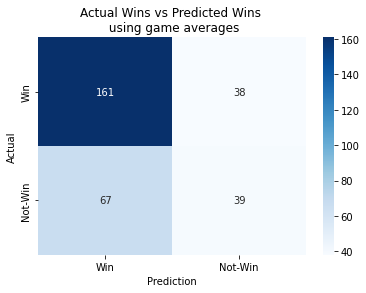

In [167]:
sns.heatmap(cm,
            annot=True,
            cmap=plt.cm.Blues,
            fmt='g',
            xticklabels=['Win', 'Not-Win'],
            yticklabels=['Win', 'Not-Win'])

plt.title("Actual Wins vs Predicted Wins \n using game averages")
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.savefig("cm_averages.jpg")
plt.show()

Comparing the previous confusion matrix we improved on the True Positives (149 to 161) and True Negatives (34 to 39). Out of the 305 games the new algorithm predicted 200 correct results.  